In [59]:
import os

In [60]:
from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

In [61]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [62]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

In [63]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [64]:
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [65]:
search = DuckDuckGoSearchRun()

In [66]:
search.invoke("who is a current president of USA?")

"The incumbent president is Joe Biden, who assumed office on January 20, 2021. [13] The president-elect is Donald Trump, who won the 2024 presidential election over Kamala Harris and will assume office on January 20, 2025. [14][15] Trump will be the second president after Grover Cleveland to serve two non-consecutive terms, as the 45th and 47th ... Updated results from the 2024 election for the US president. Reuters live coverage of the 2024 US President, Senate, House and state governors races. View live election results from the 2024 presidential race as Kamala Harris and Donald Trump face off. See the map of votes by state as results are tallied. Joe Biden is the 46th president of the United States (2021- ). He was born on November 20, 1942, in Scranton, Pennsylvania, and he served as a U.S. senator representing Delaware from 1972 to 2009. He was vice president in the Barack Obama administration from 2009 to 2017. In July 2024 Biden announced he would not seek a second term as presi

In [67]:
tools = [add, multiply, divide, search]

In [68]:
llm_with_tools=llm.bind_tools(tools)

In [69]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [70]:
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [71]:
# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

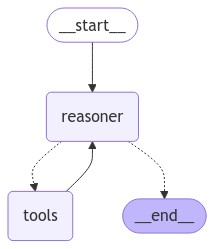

In [72]:
# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [73]:
messages = [HumanMessage(content="What is 2 times of narendramodi's age?")]

In [74]:
messages = react_graph.invoke({"messages": messages})

In [75]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of narendramodi's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_ar27)
 Call ID: call_ar27
  Args:
    query: narendra modi age
================================= Tool Message =================================
Name: duckduckgo_search

Narendra Modi is the prime minister of India since 2014 and a leader of the BJP. He was born on September 17, 1950, in Vadnagar, India, and is a member of the RSS. After releasing them into their wild, Modi also clicked their pictures. 2021: As part of efforts to tackle the Covid-19 pandemic, a record 2.26 vaccines were administered in a single day. Learn about Narendra Modi, the Prime Minister of India and the leader of the BJP. Find out his age, education, achievements, controversies, net worth and more. Born as Narendra Damodardas Modi on September 17, 1950 in the nondescript Mehsa

In [82]:
messages = [HumanMessage(content="What is the result when you add 100 years to the current age of Elon Musk?")]

In [83]:
messages = react_graph.invoke({"messages": messages})

In [84]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the result when you add 100 years to the current age of Elon Musk?
================================== Ai Message ==================================
Tool Calls:
  add (call_3k1n)
 Call ID: call_3k1n
  Args:
    a: 100
    b: 51
================================= Tool Message =================================
Name: add

151
================================== Ai Message ==================================

The result when you add 100 years to the current age of Elon Musk is 151.


In [85]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [86]:
get_stock_price("AAPL")

224.23

In [87]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [88]:
tools = [add, multiply, divide, search, get_stock_price]

In [89]:
llm_with_tools = llm.bind_tools(tools)

In [90]:
class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

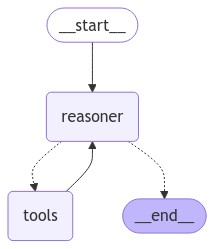

In [91]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [95]:
response = react_graph.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})

In [96]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_nqyn)
 Call ID: call_nqyn
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

224.23
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================

224.23 + 1000 = 1224.23
